In [ ]:
#If you want to obtain the results for the entanglement switched on, please set default for entanglement parameter to 1. 

In [378]:
#Making "from qencode.encoders import e1_classic" work in the jupyter notebook
import sys
import os
sys.path.insert(0, '../')

#importing libraries
import pennylane as qml
import torch
from torchvision import datasets, transforms
import argparse
from scipy.linalg import sqrtm
from pennylane import numpy as np
from tqdm import tqdm
from torch.utils.data import RandomSampler, SubsetRandomSampler

#importing defined functions from the repository
from qencode.encoders import e1_classic

In [408]:
#Defining arguments 
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=32)
parser.add_argument('--img_width', default=4)
parser.add_argument('--img_height', default=4)
parser.add_argument('--nr_batches_per_epoch', default=10)
parser.add_argument('--entanglement', default=1) #0 = no entanglement, 1= entanglement assisted

#args = parser.parse_args()       # running not in notebook
args = parser.parse_args(args=[]) # running in notebook 

In [409]:
#Importing MNIST dataset
def get_dataset(img_width, img_height, train):
    trainset = datasets.MNIST(root='./dataset', train=train, download=True,
                              transform=transforms.Compose(
                                  [transforms.Resize((img_width, img_height)), transforms.ToTensor()])
                              )
    return trainset

#Creating train and test datasets
train_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=True), \
                                           batch_size=args.batch_size, sampler=RandomSampler(get_dataset(args.img_width, args.img_height, train=True), replacement=True, num_samples=args.nr_batches_per_epoch*args.batch_size))
test_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=False), batch_size=1, sampler = SubsetRandomSampler([i for i in range(1000)]))

In [410]:
#defining number of qubits (distinguishing the case with and without entanglement)

wires=[0,1,2,3,4,5,6,7] #data_qubits = 1,2,3,4; ref_qubits = 5,6,7; swap_test_qubit=0
if args.entanglement == 1:
    wires=[0,1,2,3,4,5,6,7,8,9,10,11] #ent qubits = 8,9,10,11

#setting up a quantum device 
dev = qml.device("default.qubit", wires=wires)
shots = 1024

In [411]:
#defining the Quantum Auto Encoder circuit with and without entanglement
@qml.qnode(dev)
def QAE(inputs,encoder_params,do_what): 
#do_what=0 train;do_what=1 return the density matrix of initial state; do_what=2 return the density matrix of the decoded state
    
    
    #INITIALIZATION:
    #Encode a picture using Amplitude Embedding
    qml.AmplitudeEmbedding(inputs, wires=[1,2,3,4],normalize=True)
    
    #Encode a picture using Angle Embedding
    """
    qml.templates.embeddings.AngleEmbedding(
        inputs, wires=[1,2,3,4], rotation="X"
    )
    """
    if do_what==1:
        return qml.density_matrix([1,2,3,4])
    
    #Prepare entanglement qubits
    if args.entanglement == 1:
        
        #Creating a Bell state on the 1st pair
        qml.Hadamard(wires=8)
        qml.CNOT(wires=[8,10])
        #Creating a Bell state on the 2nd pair
        qml.Hadamard(wires=9)
        qml.CNOT(wires=[9,11])
    #Reference qubits require no preparation
    
    #ENCODER
    if args.entanglement == 0:
        e1_classic(encoder_params,[1,2,3,4]) 
    elif args.entanglement == 1:
        e1_classic(encoder_params,[1,2,3,4,8,9]) 

        
    #OUTPUT for training
    if do_what==0:  
        #SWAP TEST
        qml.Hadamard(0)
        qml.CSWAP(wires=[0,1,5])
        qml.CSWAP(wires=[0,2,6])
        qml.CSWAP(wires=[0,3,7])
        if args.entanglement == 1:
            qml.CSWAP(wires=[0,8,10])
            qml.CSWAP(wires=[0,9,11])
        qml.Hadamard(0)
        return qml.probs(wires=0)

    #DECODER
    if args.entanglement == 0:
        qml.adjoint(e1_classic)(encoder_params, [5,6,7,4])
    elif args.entanglement == 1:
        qml.adjoint(e1_classic)(encoder_params, [5,6,7,4,10,11])
        
    if args.entanglement == 0:
        return qml.density_matrix([5,6,7,4])
    elif args.entanglement == 1:
        return qml.density_matrix([5,6,7,4])

    

In [412]:
#Calculating the number of parameters in the encoder
nr_qubits_encoder = 4
if args.entanglement == 1:
    nr_qubits_encoder = 6
    
nr_par_encoder = 2 * 3 * nr_qubits_encoder + 3 * (nr_qubits_encoder - 1) * nr_qubits_encoder

In [413]:
#Defining the loss function
def loss_function(datapoint, params):
    circuit_output =  QAE(datapoint,params,0)
    return 2*(1 - circuit_output[0])

In [414]:
#Optimizing the parameters of the encoder 
opt = qml.AdamOptimizer()
epochs = 40

#Cost function - Imposing fidelity=1 for the trash and reference qubits
def cost(params, batch):
    loss = 0.0
    for datapoint in batch:
        loss += loss_function(datapoint, params)
    return loss / batch.shape[0]

In [415]:
#Initializing parameters
params = np.random.normal(size=(nr_par_encoder), requires_grad=True)

In [416]:
#with open('feb22_17_no_ent.npy', 'rb') as f:
#    params = np.load(f)

In [417]:
#Running the training
for i in range(epochs):
    print(f'Epoch {i}')
    loss = 0
    for batch, y in tqdm(train_loader):
        batch = batch.reshape(-1, args.img_height*args.img_width)
        loss += cost(params,batch)
        params = opt.step(cost, params, batch=batch)
    print(loss / args.nr_batches_per_epoch)
    

Epoch 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


0.9160364374912936
Epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.84s/it]


0.8637309372523803
Epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.88s/it]


0.8083782784754161
Epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.84s/it]


0.7393983826623483
Epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.89s/it]


0.6609621666394698
Epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.85s/it]


0.573411052130161
Epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.07s/it]


0.5041483708729269
Epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.43s/it]


0.4452371347857449
Epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.30s/it]


0.39893117485754
Epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.91s/it]


0.35670825933766387
Epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.94s/it]


0.30855514152194374
Epoch 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.25s/it]


0.26382873395158973
Epoch 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.05s/it]


0.22854886011572856
Epoch 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.01s/it]


0.20038115004798587
Epoch 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.10s/it]


0.1769666836136357
Epoch 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.09s/it]


0.15931167110643335
Epoch 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.97s/it]


0.14469411152376774
Epoch 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.93s/it]


0.13425594011677602
Epoch 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.86s/it]


0.12235018577631931
Epoch 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.80s/it]


0.11892797408452971
Epoch 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.97s/it]


0.11299315099785415
Epoch 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.95s/it]


0.10421080573699168
Epoch 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.64s/it]


0.1018505674407427
Epoch 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.35s/it]


0.10625314078595653
Epoch 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.91s/it]


0.10097163301683516
Epoch 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.33s/it]


0.1088916354662525
Epoch 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.91s/it]


0.10258336034481534
Epoch 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.91s/it]


0.09912435181514269
Epoch 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.79s/it]


0.09959332582114341
Epoch 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.85s/it]


0.09877272416545453
Epoch 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.43s/it]


0.10429168758793558
Epoch 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


0.10513540102928794
Epoch 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.06s/it]


0.10031729773232093
Epoch 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.89s/it]


0.09459074969740164
Epoch 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


0.09784619664384388
Epoch 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.94s/it]


0.10199019368715981
Epoch 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.01s/it]


0.09745572493689178
Epoch 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.94s/it]


0.10064011155509578
Epoch 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.93s/it]


0.09407442334566138
Epoch 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.96s/it]

0.09869363268695483


In [419]:
#Evaluating the faithfulness of the Quantum Auto Encoder

def fidelity(rho, sigma):
    # Inputs rho and sigma are density matrices
    sqrt_sigma = sqrtm(sigma)
    fid = np.trace(sqrtm(sqrt_sigma @ rho @ sqrt_sigma))
    return fid.real

def evaluate_similarity(datapoint, params):
    state_before=QAE(datapoint, params, 1)
    state_after=QAE(datapoint, params, 2)
    return fidelity(state_before, state_after)

In [420]:
results = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.64it/s]


In [420]:
results_new = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results_new.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.64it/s]


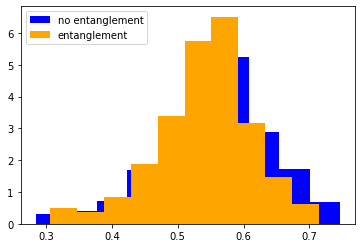

In [421]:
import matplotlib.pyplot as plt
plt.hist(results, density=True, color="blue", label="no entanglement")
plt.hist(results_new, density=True, color="orange", label="entanglement")
plt.legend()
plt.show()

In [422]:
np.array(results).mean()

tensor(0.55461167, requires_grad=True)

In [423]:
np.array(results_new).mean()

tensor(0.54055004, requires_grad=True)